In [77]:
library(dplyr)
library(data.table)
library(ggplot2)
library(viridis)

Loading required package: viridisLite


In [2]:
bamlist <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/bamlist.list.txt")
meta <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Sample_Meta.txt")[is.na(Group), Group :=-999][Group=="High", Group:=1][Group=="Low", Group:=0][, .(sample=gen_id, ucrit=Ucrit, sl=SL, dam, sire, case=Group, capture=Capture)]
sorted_meta <- left_join(bamlist, meta, by="sample")

Warning message in `[.data.table`(fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Sample_Meta.txt")[is.na(Group), :
“Coerced double RHS to character to match the type of the target column (column 10 named 'Group'). If the target column's type character is correct, it's best for efficiency to avoid the coercion and create the RHS as type character. To achieve that consider R's type postfix: typeof(0L) vs typeof(0), and typeof(NA) vs typeof(NA_integer_) vs typeof(NA_real_). You can wrap the RHS with as.character() to avoid this warning, but that will still perform the coercion. If the target column's type is not correct, it's best to revisit where the DT was created and fix the column type there; e.g., by using colClasses= in fread(). Otherwise, you can change the column type now by plonking a new column (of the desired type) over the top of it; e.g. DT[, `Group`:=as.double(`Group`)]. If the RHS of := has nrow(DT) elements then the assignment is called a c

In [4]:
head(sorted_meta)

sample,ucrit,sl,dam,sire,case,capture
Pop01_APPC1611,8.13,4.40,D125,S144,1,Pop01
Pop01_APPC1917,1.20,4.35,D85,S173,0,Pop01
Pop01_APPC1921,7.33,4.28,D85,S173,1,Pop01
Pop01_APPC2029,8.82,4.25,D70,S98,1,Pop01
Pop01_APPC2030,7.32,4.54,D70,S98,1,Pop01
Pop01_APPC2101,5.07,3.94,D269,S94,1,Pop01


## Method 1: using the observed phenotype distribution for body size (sl) and swimming ability (ucrit) but fixing se and assuming it is independent of effect size (beta). Roughly following example 3.1 in https://www.mv.helsinki.fi/home/mjxpirin/GWAS_course/material/GWAS3.html

In [196]:
#make an empty table to hold combinations of beta/maf and calculate power
ucrit_power <- data.table(maf=numeric(), beta=numeric(), power=numeric())

#range of maf to evaluate
maf <- seq(0.05,0.5, 0.01)
#set constants
n = 159 #individuals
p = 132100 #SNPs 

#loop through combinations of beta/maf and calculate power
for(i in 1:length(maf)){
    #make intermeadiate table for each evaluated maf and combinations with possible beta values
    ucrit_power_int <- data.table(beta=seq(0.1,3,0.01), maf=maf[i])
    
    #components that change with maf changes
    x = rbinom(n, 2, maf[i]) #genotypes at 1 SNP for n ind 
    y = sorted_meta$sl #phenotype distribution
    se = summary( lm( y ~ x ) )$coeff[2,2] #pick se, and assume it stays constant and independent of beta
    q.thresh = qchisq(5e-08, df = 1, ncp = 0, lower = FALSE) #repeating thresholds in chi-square units
    
    #calculate power
    ucrit_power_int[,power:=pchisq(q.thresh, df = 1, ncp = (beta/se)^2, lower = FALSE)[1], by="beta"]

#bind intermmediate table with main table
ucrit_power <- rbind(ucrit_power, ucrit_power_int)
    }
head(ucrit_power)

maf,beta,power
0.05,0.10,0.008947863
0.05,0.11,0.019727280
0.05,0.12,0.039967772
0.05,0.13,0.074551655
0.05,0.14,0.128323504
0.05,0.15,0.204402723


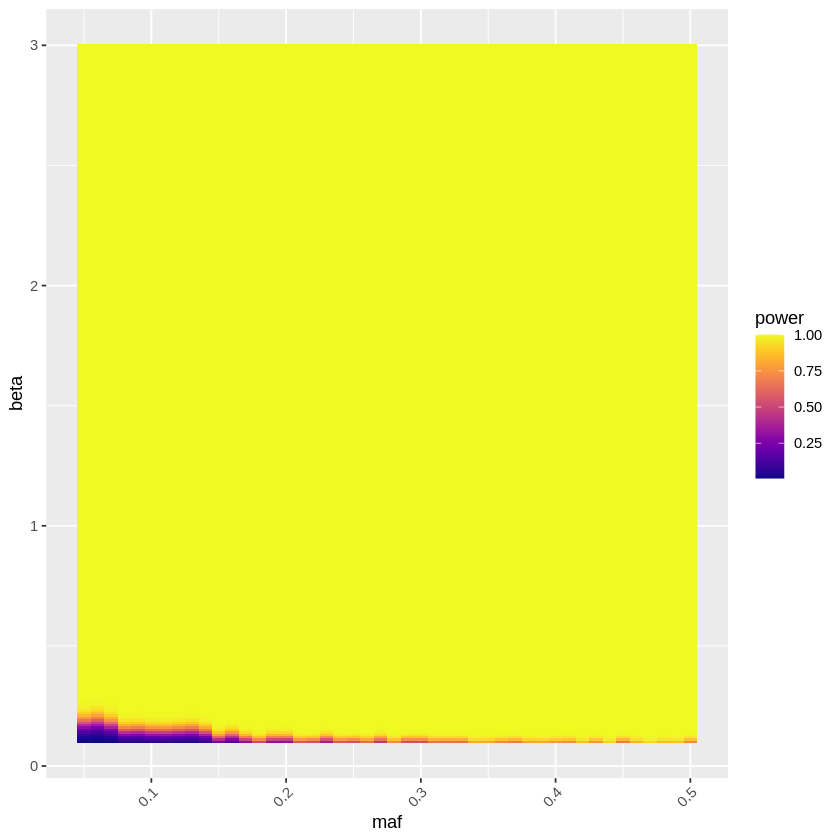

In [197]:
ucrit_power_plot <- ggplot(ucrit_power, aes(maf, beta)) + 
    geom_tile(aes(fill = power))+
 #   coord_fixed(ratio = 1) +
    theme(axis.text.x=element_text(angle=45,hjust=1))+
    scale_fill_viridis(option="plasma", name="power")
ucrit_power_plot

In [198]:
summary(sorted_meta$sl)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  3.920   4.160   4.270   4.254   4.350   4.560      12 

In [199]:
#make an empty table to hold combinations of beta/maf and calculate power
sl_power <- data.table(maf=numeric(), beta=numeric(), power=numeric())

#range of maf to evaluate
maf <- seq(0.05,0.5, 0.01)
#set constants
n = 159 #individuals
p = 132100 #SNPs 

#loop through combinations of beta/maf and calculate power
for(i in 1:length(maf)){
    #make intermeadiate table for each evaluated maf and combinations with possible beta values
    sl_power_int <- data.table(beta=seq(0.1,1,0.01), maf=maf[i])
    
    #components that change with maf changes
    x = rbinom(n, 2, maf[i]) #genotypes at 1 SNP for n ind 
    y = sorted_meta$sl #phenotype distribution
    se = summary( lm( y ~ x ) )$coeff[2,2] #pick se, and assume it stays constant and independent of beta
    q.thresh = qchisq(5e-08, df = 1, ncp = 0, lower = FALSE) #repeating thresholds in chi-square units
    
    #calculate power
    sl_power_int[,power:=pchisq(q.thresh, df = 1, ncp = (beta/se)^2, lower = FALSE)[1], by="beta"]

#bind intermmediate table with main table
sl_power <- rbind(sl_power, sl_power_int)
    }
head(sl_power)

maf,beta,power
0.05,0.10,0.001084108
0.05,0.11,0.002344526
0.05,0.12,0.004810809
0.05,0.13,0.009370956
0.05,0.14,0.017338477
0.05,0.15,0.030493033


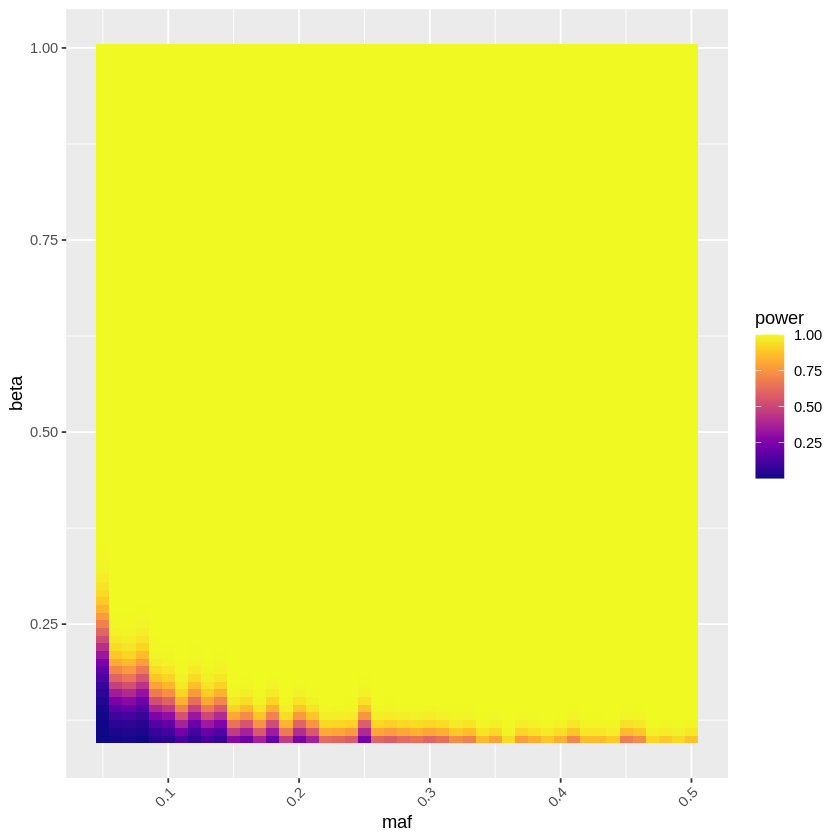

In [200]:
sl_power_plot <- ggplot(sl_power, aes(maf, beta)) + 
    geom_tile(aes(fill = power))+
 #   coord_fixed(ratio = 1) +
    theme(axis.text.x=element_text(angle=45,hjust=1))+
    scale_fill_viridis(option="plasma", name="power")
sl_power_plot

## Method 2: NOT using the observed phenotype distributions, but allowing se to vary with effect size (beta). Roughly following example 3.3 in https://www.mv.helsinki.fi/home/mjxpirin/GWAS_course/material/GWAS3.html

In [188]:
#make an empty table to hold combinations of beta/maf and calculate power
power <- data.table(maf=numeric(), beta=numeric(), y_explained=numeric(), sigma=numeric(), se=numeric(), power=numeric())

#range of maf to evaluate
maf <- seq(0.05,0.5, 0.01)
#set constants
n = 159 #individuals
p = 132100 #SNPs 

#loop through combinations of beta/maf and calculate power
for(i in 1:length(maf)){
    
    #make intermeadiate table for each evaluated maf and combinations with possible beta values
    power_int <- data.table(y_explained=seq(0.0001, 0.5, by=0.0001), maf=maf[i])
    
    #components that change with maf changes
    power_int[,beta := sqrt(y_explained / (2*maf*(1-maf))), by=c("y_explained", "maf")] #this is beta that explains the evaluated y_explained(variance explained)
    power_int[,sigma := sqrt(1 - y_explained), by=c("y_explained", "maf")] #error sd after SNP effect is accounted for, for each evaluated beta with a given maf
    power_int[,se := sigma / sqrt( n*2*maf*(1-maf)), by=c("y_explained", "maf")] #SE corresponding to n, variance explained and maf    
    q.thresh = qchisq(5e-08, df = 1, ncp = 0, lower = FALSE) #repeating thresholds in chi-square units
    
    #calculate power
    power_int[,power:=pchisq(q.thresh, df = 1, ncp = (beta/se)^2, lower = FALSE)[1], by=c("y_explained","maf")]

#bind intermmediate table with main table
power <- rbind(power, power_int)
    }
head(power)

maf,beta,y_explained,sigma,se,power
0.05,0.03244428,1e-04,0.99995,0.2572870,6.262470e-08
0.05,0.04588315,2e-04,0.99990,0.2572742,7.614642e-08
0.05,0.05619515,3e-04,0.99985,0.2572613,9.059753e-08
0.05,0.06488857,4e-04,0.99980,0.2572484,1.060111e-07
0.05,0.07254763,5e-04,0.99975,0.2572356,1.224209e-07
0.05,0.07947194,6e-04,0.99970,0.2572227,1.398613e-07


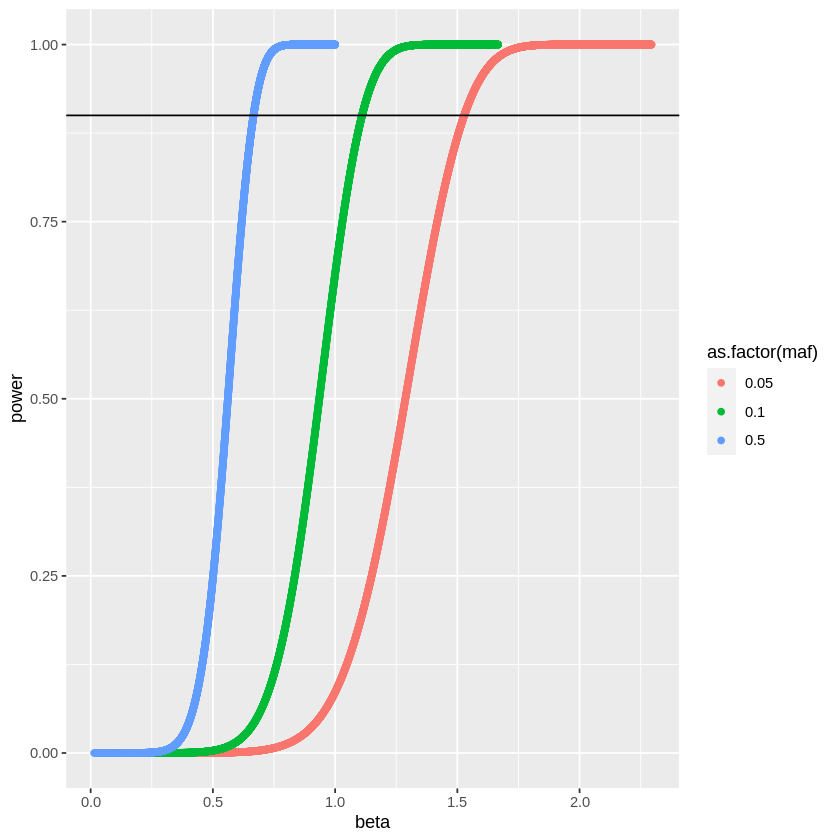

In [189]:
power_plot <- ggplot(power[maf %in% c(0.05, 0.1, 0.5)], aes(x=beta, y=power, color=as.factor(maf))) + #pick a few maf values to get a sense for the range of maf and plot those
    geom_point()+
    geom_hline(yintercept = 0.9)+
    scale_fill_viridis(option="plasma", name="power")
power_plot

## What is the smallest effect size at each maf for power to be at least .9 with either method?

In [191]:

power[maf %in% c(0.05, 0.1, 0.5)][power>=.9][, .SD[which.min(beta)], by="maf"]

maf,beta,y_explained,sigma,se,power
0.05,1.5283290,0.2219,0.8820998,0.2269642,0.9001626
0.10,1.1103053,0.2219,0.8820998,0.1648857,0.9001626
0.50,0.6661832,0.2219,0.8820998,0.0989314,0.9001626


In [201]:
ucrit_power[maf %in% c(0.05, 0.1, 0.5)][power>=.9][, .SD[which.min(beta)], by="maf"]

maf,beta,power
0.05,0.22,0.9086490
0.10,0.18,0.9283802
0.50,0.12,0.9611467


In [202]:
sl_power[maf %in% c(0.05, 0.1, 0.5)][power>=.9][, .SD[which.min(beta)], by="maf"]

maf,beta,power
0.05,0.29,0.9286218
0.10,0.18,0.9171848
0.50,0.11,0.9639845
